In [47]:
import csv
import re
def find_neurons_with_high_hydrophobicity(csv_path, string_to_match):
    matching_neurons = []

    with open(csv_path, newline='') as csvfile:
        reader = csv.reader(csvfile)
        for row in reader:
            if len(row) < 2:
                continue  # skip malformed rows
            neuron_id = row[0]
            descriptions = row[1:]  # all text columns

            if any(string_to_match in desc.lower() for desc in descriptions):
                # Extract layer and neuron number from ID like: "layer_5_neuron_310"
                match = re.match(r"layer_(\d+)_neuron_(\d+)", neuron_id)
                if match:
                    layer_num = int(match.group(1))
                    neuron_num = int(match.group(2))
                    matching_neurons.append((layer_num, neuron_num))

    return matching_neurons

In [57]:
from Bio.PDB import PDBParser
from Bio.PDB.Polypeptide import is_aa
from Bio.SeqUtils.ProtParam import ProteinAnalysis

def extract_sequence_from_pdb(pdb_file):
    parser = PDBParser(QUIET=True)
    structure = parser.get_structure("protein", pdb_file)
    residues = []
    for model in structure:
        for chain in model:
            for res in chain:
                if is_aa(res, standard=True):
                    residues.append(res.get_resname())
    # Convert 3-letter to 1-letter codes
    from Bio.Data.IUPACData import protein_letters_3to1
    seq = ''
    for r in residues:
        r = r.capitalize()
        if r in protein_letters_3to1:
            seq += protein_letters_3to1[r]
    return seq

def compute_avg_hydrophobicity(seq):
    X = ProteinAnalysis(seq)
    return X.gravy()

def compute_molecular_weight(seq):
    X = ProteinAnalysis(seq)
    return X.molecular_weight()

import freesasa

def compute_sasa(pdb_file):
    structure = freesasa.Structure(pdb_file)
    result = freesasa.calc(structure)

    print(f"Total SASA: {result.totalArea():.2f} Å²")
    return result.totalArea()

In [ ]:
import torch
from transformers import AutoTokenizer, EsmForProteinFolding
import matplotlib.pyplot as plt
from Bio.PDB import PDBParser
import numpy as np
import tempfile
import os
from tqdm import tqdm

# Load tokenizer and folding model
tokenizer = AutoTokenizer.from_pretrained("facebook/esmfold_v1")
fold_model = EsmForProteinFolding.from_pretrained("facebook/esmfold_v1")
fold_model.eval()

Some weights of the model checkpoint at facebook/esmfold_v1 were not used when initializing EsmForProteinFolding: ['esm.embeddings.position_embeddings.weight']
- This IS expected if you are initializing EsmForProteinFolding from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing EsmForProteinFolding from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of EsmForProteinFolding were not initialized from the model checkpoint at facebook/esmfold_v1 and are newly initialized: ['esm.contact_head.regression.bias', 'esm.contact_head.regression.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


EsmForProteinFolding(
  (esm): EsmModel(
    (embeddings): EsmEmbeddings(
      (word_embeddings): Embedding(33, 2560, padding_idx=1)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): EsmEncoder(
      (layer): ModuleList(
        (0-35): 36 x EsmLayer(
          (attention): EsmAttention(
            (self): EsmSelfAttention(
              (query): Linear(in_features=2560, out_features=2560, bias=True)
              (key): Linear(in_features=2560, out_features=2560, bias=True)
              (value): Linear(in_features=2560, out_features=2560, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
              (rotary_embeddings): RotaryEmbedding()
            )
            (output): EsmSelfOutput(
              (dense): Linear(in_features=2560, out_features=2560, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (LayerNorm): LayerNorm((2560,), eps=1e-05, elementwise_affine=True)
          )
          (intermediate

In [70]:
# Define neuron steering hook
def steer_neuron(model, layer_idx, neuron_idx, boost_factor):
    def hook_fn(module, input, output):
        output[:, :, neuron_idx] *= boost_factor
        return output
    return model.esm.encoder.layer[layer_idx].output.dense.register_forward_hook(hook_fn)

# Radius of Gyration
def compute_radius_of_gyration(pdb_path):
    parser = PDBParser(QUIET=True)
    structure = parser.get_structure("protein", pdb_path)
    atoms = [atom for atom in structure.get_atoms() if atom.element != "H"]
    coords = np.array([atom.coord for atom in atoms])
    centroid = np.mean(coords, axis=0)
    return np.sqrt(np.mean(np.sum((coords - centroid)**2, axis=1)))

# Save structure
def save_pdb_to_tempfile(pdb_str):
    tmp = tempfile.NamedTemporaryFile(delete=False, suffix=".pdb")
    with open(tmp.name, "w") as f:
        f.write(pdb_str)
    return tmp.name

# Run structure prediction and compute Rg
def predict_and_measure(sequence, boost_factors, matching_neurons):
# def predict_and_measure(sequence, boost_factors, layer_idx, neuron_idx):
    results = []

    for boost in tqdm(boost_factors):
        print(f"Boost factor: {boost}")

        hooks = []

        # Apply steering to all matching neurons
        for layer_idx, neuron_idx in matching_neurons:
            # print(f"Steering Layer {layer_idx}, Neuron {neuron_idx}")
            hook = steer_neuron(fold_model, layer_idx, neuron_idx, boost)
            hooks.append(hook)

        with torch.no_grad():
            inputs = tokenizer(sequence, return_tensors="pt", add_special_tokens=False)
            output = fold_model(**inputs)
            pdb_lines = fold_model.output_to_pdb(output)
            pdb_str = "\n".join(pdb_lines)

        # Save & measure
        pdb_path = save_pdb_to_tempfile(pdb_str)
        # pdb_seq = extract_sequence_from_pdb(pdb_path)
        # print(f"Extracted sequence: {pdb_seq}")
        # rg = compute_avg_hydrophobicity(pdb_seq)
        rg = compute_sasa(pdb_path)
        # rg = compute_radius_of_gyration(pdb_path)
        # rg = compute_molecular_weight(pdb_seq)
        results.append(rg)
        os.remove(pdb_path)

        for hook in hooks:
            hook.remove()

    return results

In [65]:
# first ensure that the sequence we try to predict DOES NOT already have a high value for the feature we are interested in
# this is so that we can argue that the boost factor is really having an effect
sequence = "MDDADPEERNYDNMLKMLSDLNKDLEKLLEEMEKISVQATWMAYDMVVMRTNPTLAESMRRLEDAFVNCKEEMEKNWQELLHETKQRL"

with torch.no_grad():
    inputs = tokenizer(sequence, return_tensors="pt", add_special_tokens=False)
    output = fold_model(**inputs)
    pdb_lines = fold_model.output_to_pdb(output)
    pdb_str = "\n".join(pdb_lines)

# Save & measure
pdb_path = save_pdb_to_tempfile(pdb_str)
rg = compute_sasa(pdb_path)
# pdb_seq = extract_sequence_from_pdb(pdb_path)
# rg = compute_molecular_weight(pdb_seq)
# rg = compute_avg_hydrophobicity(extract_sequence_from_pdb(pdb_path))

print(f"SASA: {rg}")
os.remove(pdb_path)

Total SASA: 8009.67 Å²
SASA: 8009.6651369090305


Number of neurons with high hydrophobicity: 65


  0%|          | 0/5 [00:00<?, ?it/s]

Boost factor: 1.0


 20%|██        | 1/5 [00:14<00:58, 14.73s/it]

Total SASA: 8219.64 Å²
Boost factor: 201.0


 40%|████      | 2/5 [00:29<00:44, 14.95s/it]

Total SASA: 10358.38 Å²
Boost factor: 401.0


 60%|██████    | 3/5 [00:44<00:30, 15.03s/it]

Total SASA: 10336.86 Å²
Boost factor: 601.0


 80%|████████  | 4/5 [00:59<00:14, 14.98s/it]

Total SASA: 9451.44 Å²
Boost factor: 801.0


100%|██████████| 5/5 [01:14<00:00, 14.93s/it]

Total SASA: 9599.04 Å²


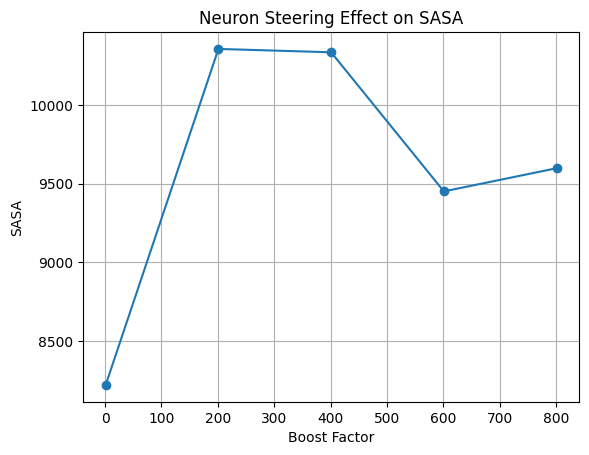

In [72]:
# Parameters
sequence = "MDDADPEERNYDNMLKMLSDLNKDLEKLLEEMEKISVQATWMAYDMVVMRTNPTLAESMRRLEDAFVNCKEEMEKNWQELLHETKQRL"
# LAYER_INDEX = 0
# NEURON_INDEX = 167

string_to_match = "high hydrophobicity"
matching_neurons = find_neurons_with_high_hydrophobicity(
    'esm35M_500k_neuron_explanations.csv',
    string_to_match
)
print(f"Number of neurons with {string_to_match}:", len(matching_neurons))

# TODO: we might want to try using negative range for boost factors too
boost_factors = [round(x, 1) for x in torch.arange(1.0, 1000, 200).tolist()]

# Run experiment
# rgs = predict_and_measure(sequence, boost_factors, LAYER_INDEX, NEURON_INDEX)
rgs = predict_and_measure(sequence, boost_factors, matching_neurons)

# Plot
plt.plot(boost_factors, rgs, marker='o')
plt.xlabel("Boost Factor")
plt.ylabel("SASA")
plt.title("Neuron Steering Effect on SASA")
plt.grid(True)
plt.show()